In [1]:
import numpy as np
import pickle
import torch
import math
import random
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from mutect3.validation import TrainingMetrics
from mutect3 import data, validation, spectrum, threshold, tensors

# we need to explicitly import in order for unpickling to work
from mutect3.tensors import Datum, SiteInfo, MutectInfo 
from mutect3.networks import ReadSetClassifier, PriorAdjustedReadSetClassifier

%matplotlib inline

In [2]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
BATCH_SIZE = 64

In [ ]:
"""
table_dir = '/Users/davidben/broad/mutect3/tables/'
pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
    print("Generating tensors for " + dream)
    
    tumor_table = table_dir + dream + '-tumor.table'
    normal_table = table_dir + dream + '-normal.table'
    
    # we form a few kinds of training data: tumor data using the normal 
    # (the normal doesn't change the format but helps make better truth guesses)
    print("Generating and pickling tumor tensors for training using tumor and normal")
    pair_train_pickle = pickle_dir + dream + '-pair-train.pickle'
    pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
    with open(pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data, f)
        
    print("Generating and pickling small (by 10x) tumor tensors for training using tumor and normal")
    small_pair_train_pickle = pickle_dir + dream + '-small-pair-train.pickle'
    random.shuffle(pair_train_data)
    original_size = len(pair_train_data)
    with open(small_pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data[:int(original_size/10)], f)
    
    #print("Generating and pickling tumor tensors for training using only tumor")
    #tumor_train_pickle = dir + dream + '-tumor-train.pickle'
    #tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
    #with open(tumor_train_pickle, 'wb') as f:
    #    pickle.dump(tumor_train_data, f)
    
    print("Generating and pickling normal tensors for training using only normal")
    normal_train_pickle = pickle_dir + dream + '-normal-train.pickle'
    normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
    with open(normal_train_pickle, 'wb') as f:
        pickle.dump(normal_train_data, f)
    
    print("Generating and pickling tumor tensors for testing using STATUS labels")
    test_pickle = pickle_dir + dream + '-test.pickle'
    test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
    with open(test_pickle, 'wb') as f:
        pickle.dump(test_data, f)
        
    print("Generating and pickling small (by 10x) tumor tensors for for testing using STATUS labels")
    small_test_pickle = pickle_dir + dream + '-small-test.pickle'
    random.shuffle(test_data)
    original_size = len(test_data)
    with open(small_test_pickle, 'wb') as f:
        pickle.dump(test_data[:int(original_size/10)], f)
"""

In [3]:
def make_data_loaders(train, valid, test):
    train_labels = [datum.artifact_label() for datum in train]
    valid_labels = [datum.artifact_label() for datum in valid]
    class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
    class_weights = 1.0/class_counts
    
    #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact
    samples_per_epoch = 20*int(class_counts[1]) 
    
    train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    valid_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[valid_labels], num_samples = 2*len(valid_labels))

    train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, sampler=valid_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=data.collate_read_sets, drop_last=True)
    return train_loader, valid_loader, test_loader

In [4]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    prior_model = spectrum.PriorModel(initial_log_ratio = 4.0)
    posterior_model = PriorAdjustedReadSetClassifier(model, prior_model)
    
    training_metrics = TrainingMetrics()
    for epoch in range(1, num_epochs + 1):
        print("Epoch " + str(epoch))
        for (loader, epoch_type) in [(train_loader, "training"), (valid_loader, "validating")]:   
            is_training = epoch_type == "training"
            model.train(is_training)
            
            # if training, we learn all parameters except for the calibration layer
            # during validation, we freeze all lower layers but learn calibration
            if is_training:
                model.unfreeze_everything_except_calibration()
            else:
                model.freeze_everything_except_calibration()
                
            epoch_loss = 0

            for batch_number, batch in enumerate(loader):
                predictions = model(batch)              
                loss = criterion(predictions, batch.labels())
                epoch_loss += loss.item()

                # note that during validation we do gradient descent but only on the calibration layer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            training_metrics.add(TrainingMetrics.NLL, epoch_type, epoch_loss / (len(loader)*BATCH_SIZE))
        
        # update the prior model, which affects the posterior model
        prior_model.learn_epoch(posterior_model, test_loader, m2_filters_to_keep={'normal_artifact'}, threshold=0.0)
        training_metrics.add(TrainingMetrics.F, "validation", validation.get_optimal_f_score(model, valid_loader))
        training_metrics.add(TrainingMetrics.F, "test", validation.get_optimal_f_score(posterior_model, test_loader, m2_filters_to_keep = {'normal_artifact'}))
    
    # model is trained
    return training_metrics, posterior_model

In [5]:
EPOCHS = 50

def run_evaluation(training_pickles, test_pickle, num_epochs=EPOCHS):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect_info().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    train_false_variants = len([_ for datum in train if (len(datum.mutect_info().filters()) > 1 or "germline" not in datum.mutect_info().filters()) and datum.artifact_label() == 0])
    print("Training data includes " + str(train_false_variants) + " artifacts labelled as good variants.")
    
    # Learn model
    train_loader, valid_loader, test_loader = make_data_loaders(train, valid, test)
    model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10]).float()
    training_metrics, posterior_model = train_model(model, train_loader, valid_loader, test_loader, num_epochs)
    training_metrics.plot_all_metrics()
    posterior_model.get_prior_model().plot_spectra()

    artifact_threshold = 1 - threshold.calculate_true_prob_threshold(posterior_model, test_loader, {'normal_artifact'})
    logit_threshold = np.log(artifact_threshold/(1 - artifact_threshold))
    print("Optimal logit threshold: " + str(logit_threshold))
    
    m3_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, [logit_threshold])[0]
    m3_stats.plot_sensitivities("Mutect3 on test set")
    m2_stats = validation.get_m2_validation_stats(test_loader)
    m2_stats.plot_sensitivities("Mutect2 on test set")
    
    roc_thresholds = [-16 + 0.25*n for n in range(128)]
    roc_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, roc_thresholds)
    sens = [stats.sensitivity() for stats in roc_stats]
    prec = [stats.precision() for stats in roc_stats]
    
    # minimum distance to sens = 1, prec = 1 corner\n",
    distance_to_corner = min(math.sqrt((1-x)**2 + (1-y)**2) for x,y in zip(sens, prec))
    print("Minimum distance to sens=1, prec=1 corner: " + str(distance_to_corner))

    roc_fig = plt.figure()
    roc_curve = roc_fig.gca()
    roc_curve.plot(sens, prec, label = "ROC curve")
    roc_curve.set_xlabel("sensitivity")
    roc_curve.set_ylabel("precision")
    roc_curve.scatter([m2_stats.sensitivity()], [m2_stats.precision()])
    roc_curve.annotate("Mutect2", (m2_stats.sensitivity(), m2_stats.precision()))
    roc_curve.scatter([m3_stats.sensitivity()], [m3_stats.precision()])
    roc_curve.annotate("Mutect3", (m3_stats.sensitivity(), m3_stats.precision()))
        

In [6]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_1_SMALL_PAIR = DIR + 'dream1-small-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_1_SMALL_TEST = DIR + 'dream1-small-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 18 PASS variants labelled as artifacts.
Training data includes 168787 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Optimal logit threshold: 0.025513125464164482
Minimum distance to sens=1, prec=1 corner: 0.03620720288568474


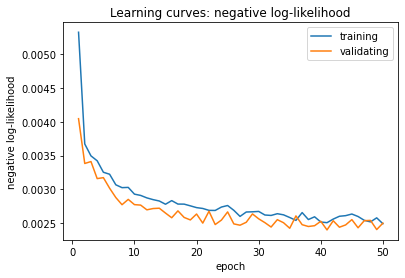

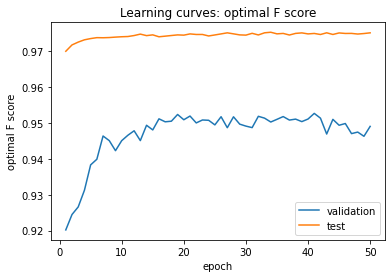

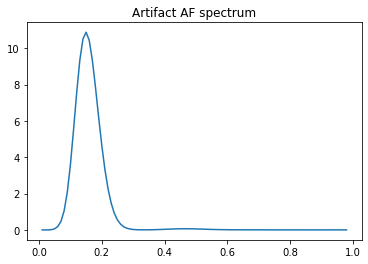

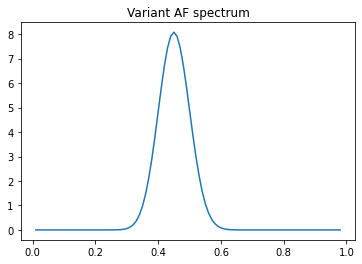

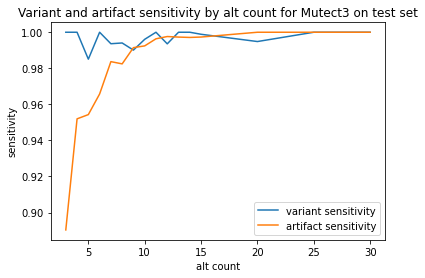

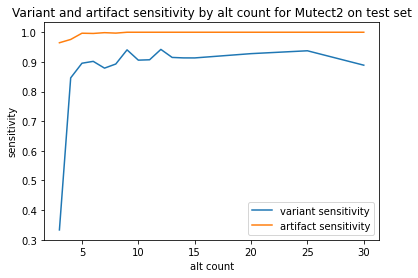

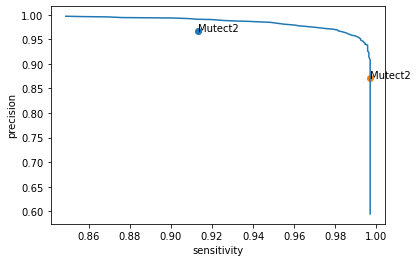

In [8]:
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 50)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 16 PASS variants labelled as artifacts.
Training data includes 168801 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Optimal logit threshold: 0.03973959257713715
Minimum distance to sens=1, prec=1 corner: 0.032301112200164274


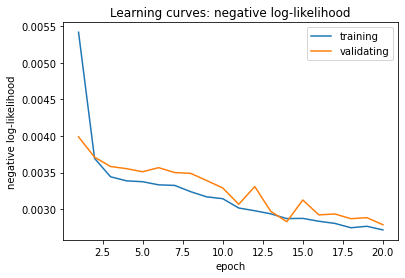

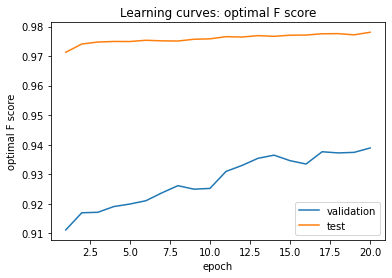

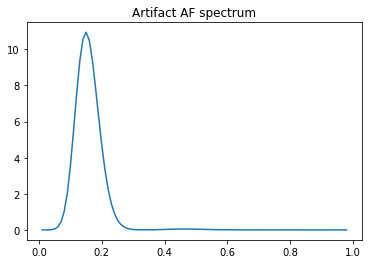

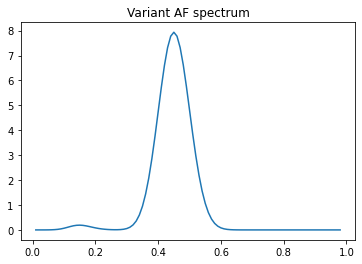

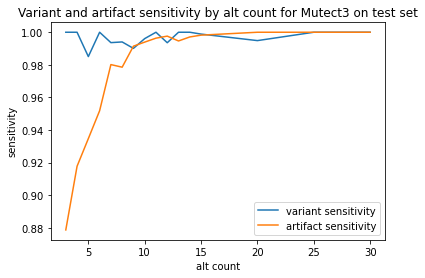

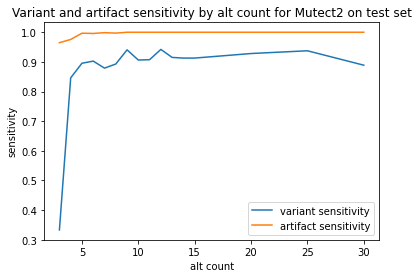

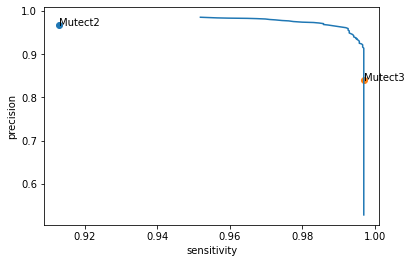

In [7]:
#leaky_relu
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 20)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 17 PASS variants labelled as artifacts.
Training data includes 168797 artifacts labelled as good variants.


/Users/davidben/broad/mutect3/mutect3/networks.py:75: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.confidence = nn.Parameter(torch.sqrt(torch.range(0, MAX_ALT)))


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Optimal logit threshold: 0.048070864007560346
Minimum distance to sens=1, prec=1 corner: 0.03827822467931526


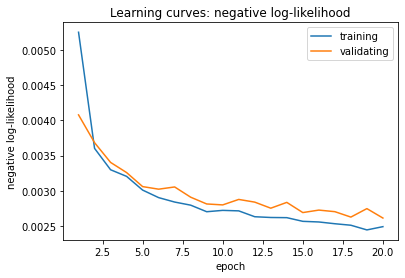

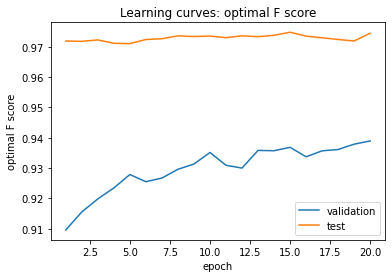

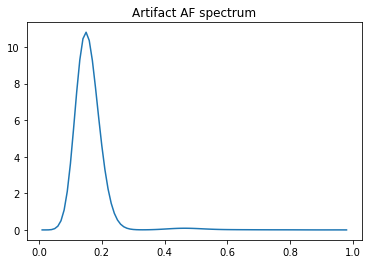

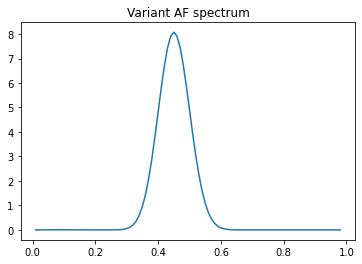

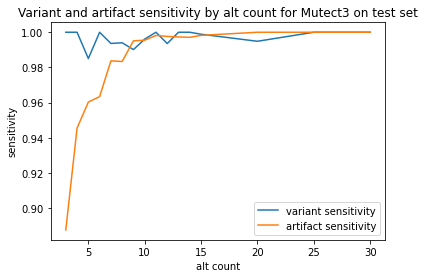

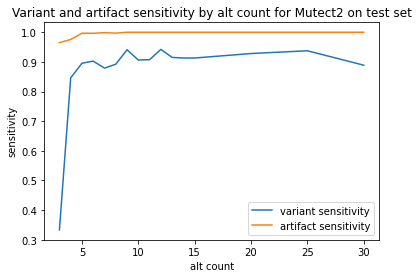

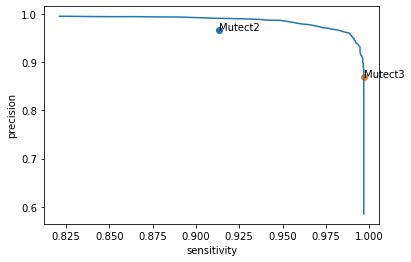

In [7]:
#leaky_relu and learnable alt count-dependent confidence
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 20)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 17 PASS variants labelled as artifacts.
Training data includes 168820 artifacts labelled as good variants.


/Users/davidben/broad/mutect3/mutect3/networks.py:75: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.confidence = nn.Parameter(torch.sqrt(torch.range(0, MAX_ALT)), requires_grad=False)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Optimal logit threshold: 0.03668409647132608
Minimum distance to sens=1, prec=1 corner: 0.03992717069907281


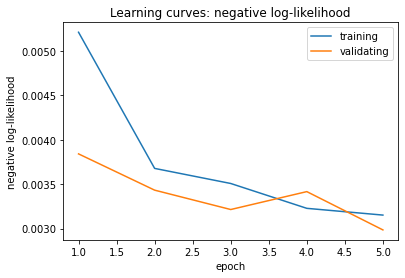

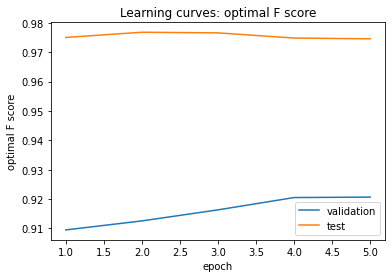

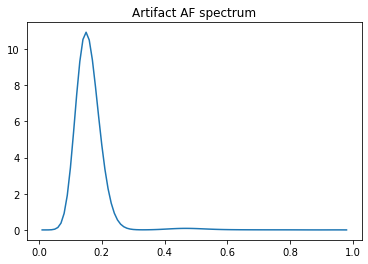

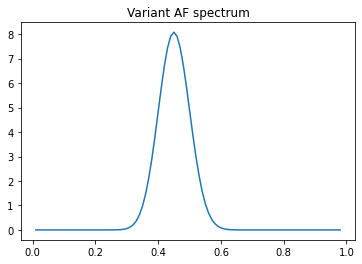

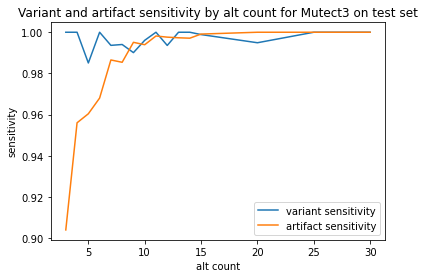

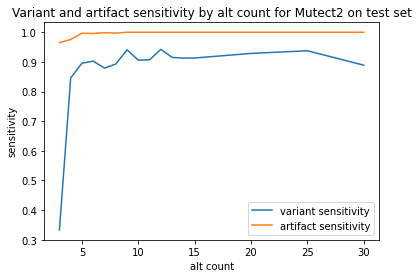

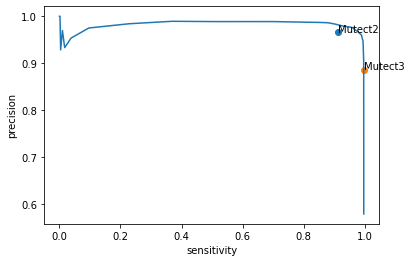

In [7]:
# SGD temperatures
#leaky_relu and learnable alt count-dependent confidence
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 5)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)